# Logistic Regression
This covers exercise 3 of Prof. Andrew Ng's ML Stanford course and closely follows part 3 of [John Wittenhauer's Python rendering of the exercise](http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/). I tried playing around with the approach to the problem and used matrix operations in place of `for` loops and explicit element-wise multiplication, though I don't think my approach is any better.
## Logistic Regression Classification
The objective of exercise three is to come up with a model that can predict whether a given student will be admitted to a school based on the candidate's scores on two exams.

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
import seaborn as sns

In [2]:
data1 = pd.read_csv('Data\\ex03.csv')

In [3]:
data1.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [4]:
groups = data1.groupby(by='admitted')
groups.describe()

exam1      exam2
admitted                            
0        count  40.000000  40.000000
         mean   52.032301  54.620392
         std    17.549050  16.081591
         min    30.058822  30.603263
         25%    35.707085  42.808798
         50%    50.410642  49.698756
         75%    61.928323  63.594638
         max    95.861555  98.869436
1        count  60.000000  60.000000
         mean   74.718923  73.956402
         std    14.912420  16.012403
         min    40.457551  43.390602
         25%    63.597244  65.409676
         50%    75.436657  74.753748
         75%    84.675745  87.442625
         max    99.827858  97.718692

In [5]:
groups.exam1.mean()

admitted
0    52.032301
1    74.718923
Name: exam1, dtype: float64

In [6]:
groups.exam2.mean()

admitted
0    54.620392
1    73.956402
Name: exam2, dtype: float64

We can immediately see that the mean `exam1` and `exam2` scores are higher in the addmited group (candidates with 1 under the `admitted` column) and the not admitted candidates.

This is shown more clearly in the below figure:

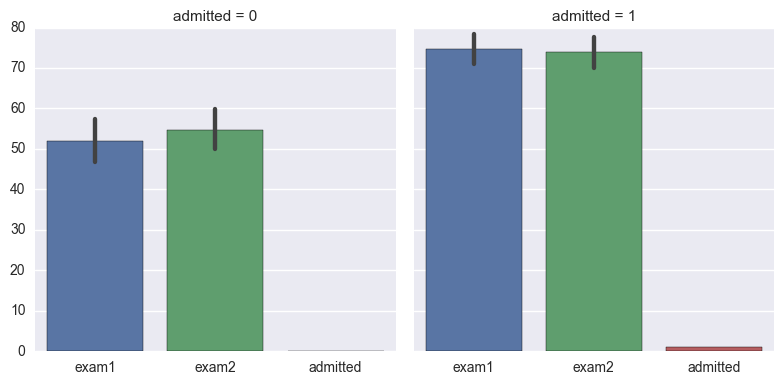

In [7]:
sns.factorplot(data=data1, col='admitted', kind='bar')

But let's just look at the raw scores:

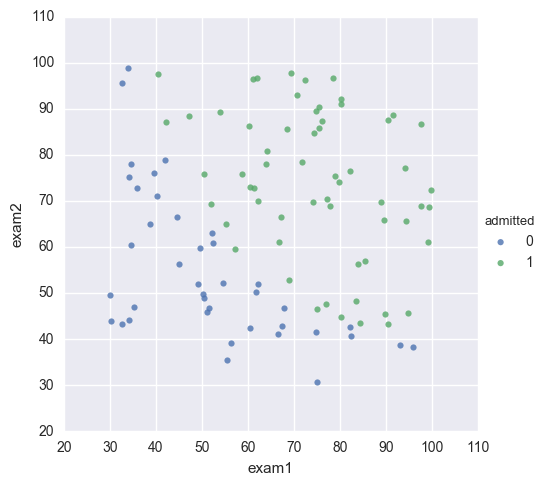

In [8]:
sns.lmplot(x='exam1', y='exam2', hue='admitted', data=data1, fit_reg=False)

It looks like an applicant's scores might predict whether he or she gets admitted. Now let's proceed with our logistic regression analysis using these variables.

### The Sigmoid Function
As shown in the lectures, the hypothesis function for a logistic regression problem is best stated as a sigmoid function as follows:

$$ {h_\theta }\left( {{{\bf{x}}_i}} \right) = g\left( z \right) = \frac{1}{{1 + {e^{ - z}}}} $$

where: $ z = {\theta ^T}{{\bf{x}}_i} $

Thus we define the following function in code:

In [9]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

### The Cost Function
The individual cost function for the $ i $-th training sample is given by:

$$ {\rm{cost}}\left( {{h_\theta }\left( {{{\bf{x}}_i}} \right),\,{y_i}} \right) =  - {y_i}\ln {h_\theta }\left( {{{\bf{x}}_i}} \right) - \left( {1 - {y_i}} \right)\ln \left( {1 - {h_\theta }\left( {{{\bf{x}}_i}} \right)} \right) $$

The overall cost for $ m $ training samples is:

$$ J\left( \theta  \right) =  - \frac{1}{m}\sum\limits_{i = 1}^m {\left[ {{y_i}\ln {h_\theta }\left( {{{\bf{x}}_i}} \right) - \left( {1 - {y_i}} \right)\ln \left( {1 - {h_\theta }\left( {{{\bf{x}}_i}} \right)} \right)} \right]}  $$

This can further be simplified into:

$$ J\left( \theta  \right) =  - \frac{1}{m}\sum\limits_{i = 1}^m {\left[ {\ln {h_\theta }\left( {{{\bf{x}}_i}} \right) + \left( {{y_i} - 1} \right){\theta ^T}{{\bf{x}}_i}} \right]}  $$

I think the above simplification is more tenable to vectorization later on, especially if we consider that the whole business inside the summation operator can be expressed in matrix form as follows:

$$ {\rm{\gamma }} + \left( {{\bf{y}} - {\bf{1}}} \right){{\bf{I}}_m}{\bf{X}}\theta  = \left[ {\begin{array}{*{20}{c}}
   \hfill {\ln {\theta ^T}{{\bf{x}}_1}} \\
   \hfill {\ln {\theta ^T}{{\bf{x}}_2}} \\
   \hfill  \vdots  \\
   \hfill {\ln {\theta ^T}{{\bf{x}}_m}} \\
\end{array}} \right] + \left[ {\begin{array}{*{20}{c}}
   \hfill {{y_1} - 1} & \hfill {} & \hfill {} & \hfill {} \\
   \hfill {} & \hfill {{y_2} - 1} & \hfill {} & \hfill {} \\
   \hfill {} & \hfill {} & \hfill  \ddots  & \hfill {} \\
   \hfill {} & \hfill {} & \hfill {} & \hfill {{y_m} - 1} \\
\end{array}} \right]\left[ {\begin{array}{*{20}{c}}
   \hfill {{\theta ^T}{{\bf{x}}_1}} \\
   \hfill {{\theta ^T}{{\bf{x}}_2}} \\
   \hfill  \vdots  \\
   \hfill {{\theta ^T}{{\bf{x}}_m}} \\
\end{array}} \right] $$

where $ \gamma  = {\left[ {\begin{array}{*{20}{c}}
   \hfill {\ln {\theta ^T}{{\bf{x}}_1}} & \hfill {\ln {\theta ^T}{{\bf{x}}_2}} & \hfill  \ldots  & \hfill {\ln {\theta ^T}{{\bf{x}}_m}} \\
\end{array}} \right]^T} $ , $ {\bf{1}} $ is an $ m $ -dimensional vector whose components are all 1, and $ {{\bf{I}}_m}$ is the $ m \times m $ identity matrix.

So, we define the following overall cost function:

In [10]:
def cost(theta, X, y):
    theta = np.matrix(theta).T
    X = np.matrix(X)
    y = np.matrix(y)
    m, _ = y.shape
    z = X * theta
    cost_i = np.log(sigmoid(z)) + np.diag(y.A1 - 1) * z
    return (-np.sum(cost_i)) / m

### Turn Everything to Numpy Arrays

In [11]:
# the target variable
m, _ = data1.shape
y = np.reshape(data1.admitted.values, (m, 1))
y.shape

(100, 1)

In [12]:
# creating the array for the design matrix
ones = np.ones(m)
exam1 = data1.exam1.values
exam2 = data1.exam2.values
X = np.array([ones, exam1, exam2]).T
X.shape

(100, 3)

In [13]:
# Defining and initializing the parameter vector theta
_, nparams = X.shape
theta = np.zeros(nparams)
theta

array([ 0.,  0.,  0.])

### Trying out the Cost Function

In [14]:
cost(X=X, y=y, theta=theta)

0.69314718055994529

### Gradient and Optimization
Based on the equation for $ J\left( \theta  \right) $, we can show that the gradient descent for finding the value of $ j $ -th parameter that minimizes the overall cost function is:

$$ {\theta _j}: = {\theta _j} - \alpha \frac{\partial }{{\partial {\theta _j}}}J\left( \theta  \right) $$

which turns out to be:

$$ {\theta _j}: = {\theta _j} - \alpha \frac{1}{m}\sum\limits_{i = 1}^m {{{\bf{x}}_i}\left[ {{h_\theta }\left( {{{\bf{x}}_i}} \right) - {y_i}} \right]}  $$

This looks exactly like the gradient descent algorithm we saw for linear regression.

Note that the (gradient term) summation term can be expressed in matrixx form as:

$$ \sum\limits_{i = 1}^m {{{\bf{x}}_i}\left[ {{h_\theta }\left( {{{\bf{x}}_i}} \right) - {y_i}} \right]}  = {{\bf{X}}^T}\left[ {{\rm{\gamma }} - {\bf{y}}} \right] $$

where 

$$ {\rm{\gamma }} = \left[ {\begin{array}{*{20}{c}}
   \hfill {g\left( {{\theta ^T}{{\bf{x}}_i}} \right)} \\
   \hfill {g\left( {{\theta ^T}{{\bf{x}}_2}} \right)} \\
   \hfill  \vdots  \\
   \hfill {g\left( {{\theta ^T}{{\bf{x}}_m}} \right)} \\
\end{array}} \right] = \left[ {\begin{array}{*{20}{c}}
   \hfill {{h_\theta }\left( {{{\bf{x}}_1}} \right)} \\
   \hfill {{h_\theta }\left( {{{\bf{x}}_2}} \right)} \\
   \hfill  \vdots  \\
   \hfill {{h_\theta }\left( {{{\bf{x}}_m}} \right)} \\
\end{array}} \right] $$

This will make it easier to write our gradient function as follows:

In [15]:
def gradient(theta, X, y):
    theta = np.matrix(theta).T
    X = np.matrix(X)
    y = np.matrix(y)
    z = X * theta
    grad = X.T * (sigmoid(z) - y)
    return (grad.A1) / y.shape[0]

Following the [approach used by J. Wittenhauer](http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/) and by Prof. Ng in this exercise, we do not explicitly write the iterations needed to arrive at the optimal values of the parameters. Rather we write the above function to return the gradient at specific values of the parameters and let scipy's optimization API compute the optimal values of theta for us.

In [16]:
# let's give this a try
gradient(X=X, y=y, theta=theta)

array([ -0.1       , -12.00921659, -11.26284221])

In [17]:
res = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
res

(array([-25.16131863,   0.20623159,   0.20147149]), 36, 0)

In [18]:
cost(theta=res[0], X=X, y=y)

0.20349770158938335

This is certainly lower than the initial cost of 0.69. According to the optimization algorithm we used, the values of the parameters (`theta`) that give the minimum possible cost are:

In [19]:
res[0]

array([-25.16131863,   0.20623159,   0.20147149])

### Building the Model and Making Predictions
We now have the parameters we need to build our model for predicting if a student gets admitted or not. The results show that

$$ {z_i} = {\hat \theta ^T}{{\bf{x}}_i} = {\left[ {\begin{array}{*{20}{c}}
   \hfill { - 25.161} \\
   \hfill {0.206} \\
   \hfill {0.201} \\
\end{array}} \right]^T}\left[ {\begin{array}{*{20}{c}}
   \hfill 1 \\
   \hfill {{x_{i,1}}} \\
   \hfill {{x_{i,2}}} \\
\end{array}} \right] =  - 25.161 + 0.206{x_{i,1}} + 0.201{x_i}_{,2} $$

where $ \hat \theta  $ is the vector of our estimated parameters and $ {x_{i,1}} $ and $ {x_{i,2}} $ are the $ i $-th student's scores on the first and second exams, respectively.

We can now make the following predictions:

$$ {\hat y_i} = \left\{ \begin{array}{l}
 1{\rm{      if  }}{z_i} > 0 \\ 
 0{\rm{     otherwise}} \\ 
 \end{array} \right. $$
 
which is equivalent to:

$$ {\hat y_i} = \left\{ \begin{array}{l}
 1{\rm{      if  }}g\left( {{z_i}} \right) > 0.5 \\ 
 0{\rm{     otherwise}} \\ 
 \end{array} \right. $$

But we'll just use the first one so that we won't need to call the sigmoid function. Thus, our function for prediction is:

In [20]:
def predict(theta_hat, X):
    theta_hat = np.matrix(theta_hat).T
    X = np.matrix(X)
    z = X * theta_hat
    y_hat = z > 0
    return y_hat.astype(int)

In [21]:
y_hat = predict(theta_hat=res[0], X=X)

In [22]:
# Checking accuracy of prediction
y_hat = np.reshape(y_hat, (len(y_hat), 1))       # turn y_hat into mx1
correct = y == y_hat
accuracy = (np.sum(correct.astype(float)) / m) * 100
accuracy

89.0